# Spinal cord injury analysis

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

## Dataset

The data comes from the National Spinal Cord Injury Statistical Center (NSCISC).

Unpack it a `data` directory as follows for scripts to find it:
```
data
├── f1_public_2021.csv
└── f2_public_2021.csv
```

The two files contain responses to two forms, f1 and f2. The first form is administered at injury time. The second is recurring, first one year after the injury, then five, then every five years after this.

The vast majority of columns are categories whose definitions are given in a data dictionary, but we keep them as strings and integers for now to facilitate computations. The columns explicitely listed below contain a mix of integers and strings (e.g. `32` and `"6-12y"`) so we import them as strings to avoid warnings.

In [2]:
df1 = pd.read_csv(
    "data/f1_public_2021.csv",
    dtype={col_name: str for col_name in ['AExtCsIj', 'AASAImAd', 'AASAImDs', 'AInjAge']},
)
df2 = pd.read_csv(
    "data/f2_public_2021.csv",
    dtype={col_index: str for col_index in ['BASAImp']},
)

The two forms have a single column in common, a unique ID per patient called `UniID`, so we can merge them into a single long-form dataframe.

In [3]:
df = pd.merge(df2, df1, on='UniID', how='left')

Let's look at how many records we're starting with:

In [4]:
df1.shape[0], df2.shape[0], df.shape[0]

(35675, 131217, 131217)

## Research questions

We'd like to answer the following questions:

1. Do people with high functional scores still report low engagement in leisure or screen-based activities?
2. Do higher depression scores correlate with lower leisure/screen engagement?
3. Are younger people more likely to engage in screen-based leisure?
4. Do mobility users report lower participation?
5. Is lower income associated with reduced leisure and higher depression?

To do that, we have to identify the relevant columns and compute some aggregated scores.

### Functionality

Let's start with functional scores.

In [5]:
functional_columns = {
    'ACrEat': 'Self-Care A. Eating',
    'ACrOrl': 'Self-Care B. Oral Hygiene',
    'ACrTlHy': 'Self-Care C. Toileting hygiene',
    'ACrShr': 'Self-Care E. Shower/bathe self',
    'ACrUpDr': 'Self-Care F. Upper body dressing',
    'ACrLrDr': 'Self-Care G. Lower body dressing',
    'ACrFtr': 'Self-Care H. Putting on/taking off footwear',
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}

All these columns correspond to functional scores and share the same response category.

In [6]:
functional_category = {
  1: 'Dependent',
  2: 'Substantial/maximal assistance',
  3: 'Partial/moderate assistance',
  4: 'Supervision or Touching Assistance',
  5: 'Setup or clean-up assistance',
  6: 'Independent',
  7: 'Patient Refused',
  9: 'Not applicable',
  10: 'Not attempted due to environmental limitations',
  88: 'Not attempted due to medical condition or safety concerns',
  99: 'Unknown, No rehab admit',
}

Note that we exclude:
- `ACrCh`: Wheel Q. Does patient use wheelchair/scooter
- `ACrT50`: Wheel RR Type of wheelchair/scooter used
- `ACrT150`: Wheel SS 150 Ft Type of wheelchair/scooter used

even though they are functional responses because they use a different category (yes/no).

Also note that each column actually maps to two columns because the same questions get evaluated twice, once at the start of rehab and once at discharge. They're differentiated by the suffixes `R` and `D`.

In [7]:
functional_columns = [f'{key}{suffix}' for key in functional_columns.keys() for suffix in ['R', 'D']]

Next we can compute the average functional score. Since it's only using data from form 1, we prefix the new column with `A` for consistency.

We must be careful to exclude invalid values.

In [8]:
df1['AFunctionalScore'] = df1[functional_columns][df1[functional_columns] < 7].dropna(how='all', axis=0).mean(axis=1)

Let's add that new colum to `df`.

In [9]:
df = pd.merge(df, df1[['UniID', 'AFunctionalScore']], on='UniID', how='left')

How many rows did we drop for lack of any functional scores?

In [10]:
(
    df1.dropna(subset='AFunctionalScore').shape[0],
    df1.dropna(subset='AFunctionalScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalScore').shape[0],
    df.dropna(subset='AFunctionalScore').shape[0] / df.shape[0],
)
# (3249, 0.09107217939733707, 2215, 0.016880434699772132)

(3249, 0.09107217939733707, 2215, 0.016880434699772132)

Sadly, that's a 91% reduction in terms of form 1 and 99% for form 2.

We can also try a different set of columns that should also capture a functional score.

In [11]:
functional_alt_columns = {
    'ASFBMTS': 'Basic Mobility T-Score',
    'ASFSCTS': 'Self-Care T-Score',
    'ASFFMoTS': 'Fine Motor T-Score',
    'ASFAmbTS': 'Ambulation T-Score',
    'ASFMWhTS': 'Manual Wheelchair Mobility T-Score',
    'ASFPWhTS': 'Power Wheelchair Mobility T-Score',
}.keys()

In [12]:
df1["AFunctionalAltScore"] = (
    df1[functional_alt_columns][
        (df1[functional_alt_columns] >= 0) & (df1[functional_alt_columns] <= 100)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [13]:
df = pd.merge(df, df1[['UniID', 'AFunctionalAltScore']], on='UniID', how='left')

In [14]:
(
    df1.dropna(subset='AFunctionalAltScore').shape[0],
    df1.dropna(subset='AFunctionalAltScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalAltScore').shape[0],
    df.dropna(subset='AFunctionalAltScore').shape[0] / df.shape[0],
)

(3241, 0.0908479327259986, 2292, 0.017467248908296942)

Unfortunately, we get a similar reduction in entries. So let's try yet another measure.

In [15]:
functional_alt_alt_columns = {
    'AFScorRb': 'Functional Independence Measure - Total Score - Rehab Admit',
    'AFScorDs': 'Functional Independence Measure - Total Score - Rehab Discharge',
}.keys()

In [16]:
df1["AFunctionalAltAltScore"] = (
    df1[functional_alt_alt_columns][
        (df1[functional_alt_alt_columns] >= 0) & (df1[functional_alt_alt_columns] < 99)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [17]:
df = pd.merge(df, df1[['UniID', 'AFunctionalAltAltScore']], on='UniID', how='left')

In [18]:
df["AFunctionalAltAltScore"].dropna()

1744      37.5
1745      37.5
1746      37.5
1747      37.5
1849      84.0
          ... 
129341    72.5
129342    72.5
129343    72.5
129344    72.5
129345    72.5
Name: AFunctionalAltAltScore, Length: 57894, dtype: float64

In [19]:
(
    df1.dropna(subset='AFunctionalAltAltScore').shape[0],
    df1.dropna(subset='AFunctionalAltAltScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalAltAltScore').shape[0],
    df.dropna(subset='AFunctionalAltAltScore').shape[0] / df.shape[0],
)

(20494, 0.5744639103013315, 57894, 0.4412080751731864)

Hooray! Only 43% dropped.

### Depression

For depression, we can use pre-calculated columns. `ABPHQMDS` (PHQ-9 Major Depressive Syndrome) is a three-level scale (major/other/none) that gets calculated based on specific criteria. `ABPHQSDS` (PHQ-Severity of Depression) is the sum of responses to individual screening questions so is more granular (0 to 27) but does not map to a specific diagnostic. We'll stick with `ABPHQMDS` for now.

In [20]:
depression_columns = ['ABPHQMDS', 'BPHQMDS']

In [21]:
depression_category = {
    0: 'No depressive syndrome',
    1: 'Major depressive syndrome',
    2: 'Other depressive syndrome',
    7: 'Declined',
    9: 'Unknown, interview not done, age <18',
}

Even if it's a single column, let's create a new column excluding invalid entries.

In [22]:
depression_a_columns = [col for col in depression_columns if col.startswith('A')]
df1['ADepressionScore'] = df1[depression_a_columns][df1[depression_a_columns] < 3].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ADepressionScore']], on='UniID', how='left')

Let's see how many rows we have with a depression score.

In [23]:
(
    df1.dropna(subset='ADepressionScore').shape[0],
    df1.dropna(subset='ADepressionScore').shape[0] / df1.shape[0],
    df.dropna(subset='ADepressionScore').shape[0],
    df.dropna(subset='ADepressionScore').shape[0] / df.shape[0],
)

(3253, 0.0911843027330063, 2289, 0.017444386017055717)

We lost 91% of the rows.

### Age

For form 1, the age at time of injury is provided. For form 2, the age is calculated by summing the age at time of injury with the years since the injury happened. But since ages for minors and seniors are reported as age group strings like `6-12y` or `88+`, we have to add years since the injury to individual numbers within each string.

In [24]:
def add(text, num):
    return re.sub(r'\d+', lambda match: str(int(match.group(0)) + num), text)

It's important to use the correct age column depending on the form. Thankfully column names are prefixed with `A` or `B` depending on the form, so we use that same convention to compute the age for form 2.

In [25]:
df['BAge'] = df.apply(lambda row: add(row['AInjAge'], row['BYear']), axis=1)

In [26]:
(
    df.dropna(subset='BAge').shape[0],
    df.dropna(subset='BAge').shape[0] / df.shape[0],
)

(131217, 1.0)

### Mobility

Mobility questions are a subset of functional questions.

In [27]:
mobility_columns = {
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}
mobility_columns = [f'{key}{suffix}' for key in mobility_columns.keys() for suffix in ['R', 'D']]

In [28]:
df1['AMobilityScore'] = df1[mobility_columns][df1[mobility_columns] < 7].dropna(how='all', axis=0).mean(axis=1)
df = pd.merge(df, df1[['UniID', 'AMobilityScore']], on='UniID', how='left')

In [29]:
(
    df1.dropna(subset='AMobilityScore').shape[0],
    df1.dropna(subset='AMobilityScore').shape[0] / df1.shape[0],
    df.dropna(subset='AMobilityScore').shape[0],
    df.dropna(subset='AMobilityScore').shape[0] / df.shape[0],
)

(3244, 0.09093202522775053, 2210, 0.016842329881036757)

### Income

Income is readily available in both forms, as a category.

In [30]:
income_columns = ['AFmIncLv', 'BFmIncLv']

In [31]:
income_category = {
    1: '< $25,000',
    2: '$25,000 - $49,999',
    3: '$50,000 - $74,999',
    4: '$75,000 plus',
    6: 'Participant doesn’t know',
    7: 'Declined',
    9: 'Unknown/Interview not done',
}

In [32]:
income_a_columns = [col for col in income_columns if col.startswith('A')]
income_b_columns = [col for col in income_columns if col.startswith('B')]
df1['AIncome'] = df1[income_a_columns][df1[income_a_columns] < 6].dropna(how='all', axis=0).mean(axis=1)
df = pd.merge(df, df1[['UniID', 'AIncome']], on='UniID', how='left')
df['BIncome'] = df[income_b_columns][df[income_b_columns] < 6].dropna(how='all', axis=0)

In [33]:
(
    df1.dropna(subset='AIncome').shape[0],
    df1.dropna(subset='AIncome').shape[0] / df1.shape[0],
    df.dropna(subset='BIncome').shape[0],
    df.dropna(subset='BIncome').shape[0] / df.shape[0],
)

(5704, 0.15988787666433077, 31100, 0.23701197253404666)

### Leisure and screen-based activities

Leisure and screen-based activities are central to the research questions we're trying to answer yet there is very little relevant corresponding data. We have to content ourselves with indirect answers like _I found new things to enjoy_ or _Internet or Email Usage, how often_.

In [34]:
leisure_columns = ['ARsNewTh']

In [35]:
screen_based_activities_columns = ['BInetEml']

Unfortunately, those columns don't figure in the data dictionary so we don't know for sure what categories they use. However, we can guess their range and still compute a score.

In [36]:
leisure_category = {
    1: 'Not at all',
    2: 'A little bit',
    3: 'Somewhat',
    4: 'Quite a bit',
    5: 'Very much',
    7: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

In [37]:
screen_based_activities_category = {
    0: 'Never',
    1: 'Rarely',
    2: 'Often',
    3: 'All the time',
    8: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

Let's add columns for them too.

In [38]:
df1['ALeisureScore'] = df1[leisure_columns][df1[leisure_columns] < 6].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ALeisureScore']], on='UniID', how='left')

In [39]:
df['BScreenScore'] = df[screen_based_activities_columns][df[screen_based_activities_columns] < 4].dropna(how='all', axis=0)

In [40]:
(
    df1.dropna(subset='ALeisureScore').shape[0],
    df1.dropna(subset='ALeisureScore').shape[0] / df1.shape[0],
    df.dropna(subset='BScreenScore').shape[0],
    df.dropna(subset='BScreenScore').shape[0] / df.shape[0],
)

(3313, 0.09286615276804484, 29924, 0.22804971916748593)

### Participation

Lastly, we need to measure participation. I interpret this to mean participation in social activities, rather than participation to the survey which would be hard to measure. We'll use the _social integration_ computed column `BCHSocIn` which is a score between 0 and 100.

In [41]:
participation_columns = ['BCHSocIn']

In [42]:
df['BParticipationScore'] = df[participation_columns][df[participation_columns] < 101].dropna(how='all', axis=0)

In [43]:
(
    df.dropna(subset='BParticipationScore').shape[0],
    df.dropna(subset='BParticipationScore').shape[0] / df.shape[0],
)

(46376, 0.3534298147343713)

## Control variables

To better answer the research questions, we need to include control variables that might represent confounding factors in our analysis.

We already loaded the age but there is more demographic and socioeconomic data that is relevant.

In [44]:
demographic_columns = [
    'ASex', # Sex
    'ARace', # Racial or Ethnic Group
    'AHispnic', # Hispanic Origin
]
socioeconomic_columns = [
    'AEducLvl', # Highest Formal Educational Level Completed at Injury
    'BEducLvl', # Highest Formal Educational Level Completed
    'AMarStIj', # Marital Status at Injury 
    'BMarStat', # Marital Status on the Anniversary
    'APrLvlSt', # Primary Occupational, Educational or Training Status
    'BPrLvlSt', # Primary Occupational, Educational or Training Status
]

Relatedly, we can include social and environmental controls which can affect access to activities and social support.

In [45]:
living_situation_columns = [
    'APResInj', # Place of residence at injury
    'APResDis', # Place of residence at discharge
    'BPlcRes', # Place of residence at follow-up
]
social_participation_columns = [
    # 'BCHSocIn', # CHART Social Integration (already using this as participation)
    'BCHPITot', # CHART Physical Independence Total
    'BCHMbTot', # CHART Mobility Total
    'BCHOpTot', # CHART Occupation Total
]

Also relevant are health/injury severity variables.

In [46]:
injury_columns = [
    # 'ANurLvlA', # Neurologic level of injury at acute med unit admit 
    # 'ANurLvlR', # Neurologic level of injury at admit to rehab
    'ANurLvlD', # Neurologic level of injury at discharge
    # 'BNurLvl', # Neurologic level of injury at annual exam
    # 'AASAImAd', # ASIA Impairment Scale at acute med unit exam
    # 'AASAImRb', # ASIA Impairment Scale at admit to system inpatient rehab
    'AASAImDs', # ASIA Impairment Scale at discharge
    # 'BASAImp', # ASIA Impairment Scale at annual exam
]
pain_columns = [
    'BPainSev', # Pain usual level last 4 weeks
    'BPainWrk', # Pain interference last 4 weeks
]
health_columns = [
    'ADiabete', # Diabetes, diagnosed lifetime
    'AHypTen', # Hypertension, diagnosed lifetime
    'AHypLip', # Hyperlipidemia, diagnosed lifetime
    'AArthr', # Arthritis, diagnosed lifetime
    'BDiabete', # Diabetes, current
    'BHyptnCu', # Hypertension, current
    'BHyplpCu', # Hyperlipidemia, current
    'BArthrCu', # Arthritis, current
]
health_perception_columns =[
    'BSPHthSt', # Self-perceived health status
    'BSPHthRC', # Compared to 1 year ago, rate your health now
]

Also substance use.

In [47]:
substance_use_columns = [
    'AAlcRate', # AUDIT C - how often have a drink
    'BAlcRate', # AUDIT C - how often have a drink
    'AAlcNbDr', # AUDIT C - drinks on typical day
    'BAlcNbDr', # AUDIT C - drinks on typical day
    'AAlc6Mor', # AUDIT C - 6 or more drinks on one occasion
    'BAlc6Mor', # AUDIT C - 6 or more drinks on one occasion
    'ASATob', # WHO ASSIST score - Tobacco
    'BSATob', # WHO ASSIST score - Tobacco
    'ASACann', # WHO ASSIST score - Cannabis
    'BSACann', # WHO ASSIST score - Cannabis
    'ASACoc', # WHO ASSIST score - Cocaine
    'BSACoc', # WHO ASSIST score - Cocaine
    'ASAAmph', # WHO ASSIST score - Amphetamine-type
    'BSAAmph', # WHO ASSIST score - Amphetamine-type
    'ASAInhl', # WHO ASSIST score - Inhalants
    'BSAInhl', # WHO ASSIST score - Inhalants
    'ASASed', # WHO ASSIST score - Sedatives/Sleeping
    'BSASed', # WHO ASSIST score - Sedatives/Sleeping
    'ASAHall', # WHO ASSIST score - Hallucinogens
    'BSAHall', # WHO ASSIST score - Hallucinogens
    'ASAOpd', # WHO ASSIST score - Opiods
    'BSAOpd', # WHO ASSIST score - Opiods
    'ASAOthr', # WHO ASSIST score - Other
    'BSAOthr', # WHO ASSIST score - Other
]

And medical history.

In [48]:
mental_health_columns = [
    'AAnxiety', # Lifetime history of anxiety diagnosis
    'ADepress', # Lifetime history of depression diagnosis
]
hospitalizations_columns = [
    'BRhspNbr', # Number of rehospitalizations during last 12 months
    'BRhspDaT', # Days rehospitalized during last 12 months
]

Lastly some technology access columns.

In [49]:
technology_columns = [
    'BCompUse', # Use a computer?
    'BCmpAsst', # Computer assistance from another
    'BCellPhn', # Cell phone usage
]

Most of those columns are categorical but there are a few that are continuous.

In [50]:
continuous_controls = {
    "BCHPITot": lambda n: n < 101,
    "BCHMbTot": lambda n: n < 101,
    "BCHOpTot": lambda n: n < 101,
    "BRhspNbr": lambda n: n < 8,
    "BRhspDaT": lambda n: n < 888,
    "BPainSev": lambda n: n < 888,
}
categorical_controls = [
    col
    for col in demographic_columns
    + socioeconomic_columns
    + living_situation_columns
    + social_participation_columns
    + injury_columns
    + pain_columns
    + health_columns
    + health_perception_columns
    + substance_use_columns
    + mental_health_columns
    + hospitalizations_columns
    + technology_columns
    if col not in continuous_controls.keys()
]

## Preliminary analysis

Let's start with very simple regression plots to get a sense of the data.

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

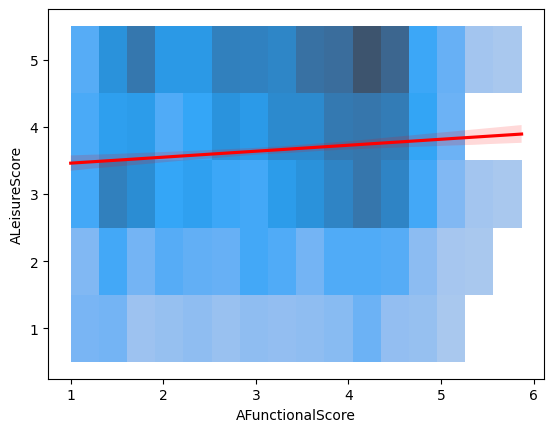

In [51]:
sns.histplot(df, x='AFunctionalScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

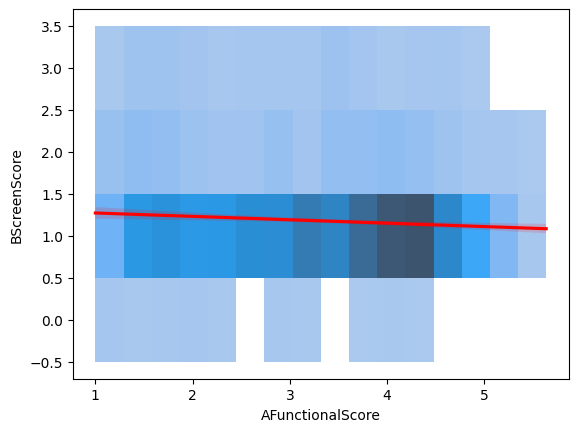

In [52]:
sns.histplot(df, x='AFunctionalScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

Let's also try with the alternative functional score.

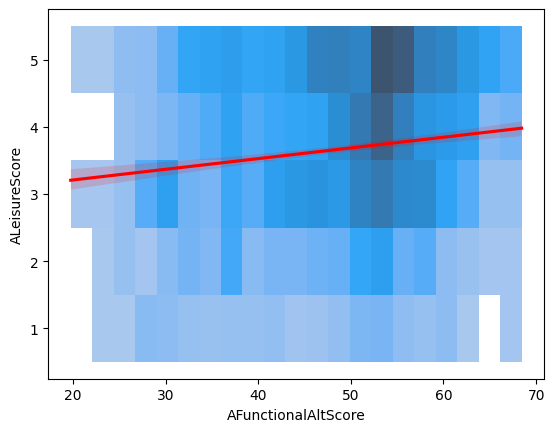

In [53]:
sns.histplot(df, x='AFunctionalAltScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

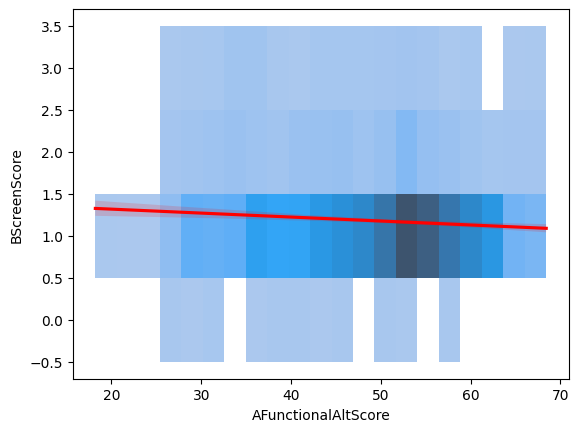

In [54]:
sns.histplot(df, x='AFunctionalAltScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

And the other alternative score.

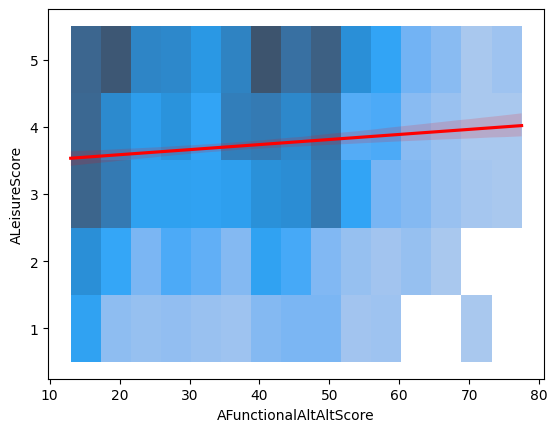

In [55]:
sns.histplot(df, x='AFunctionalAltAltScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltAltScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

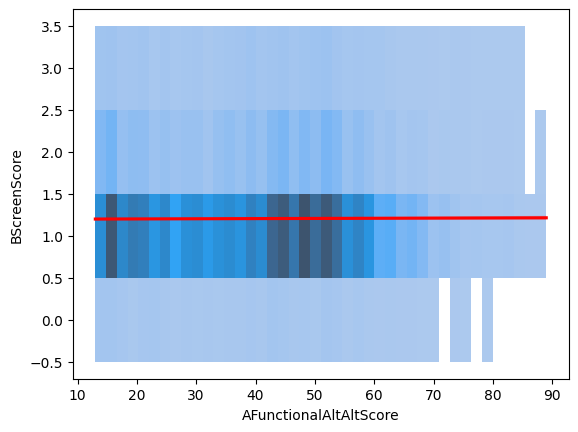

In [56]:
sns.histplot(df, x='AFunctionalAltAltScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltAltScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

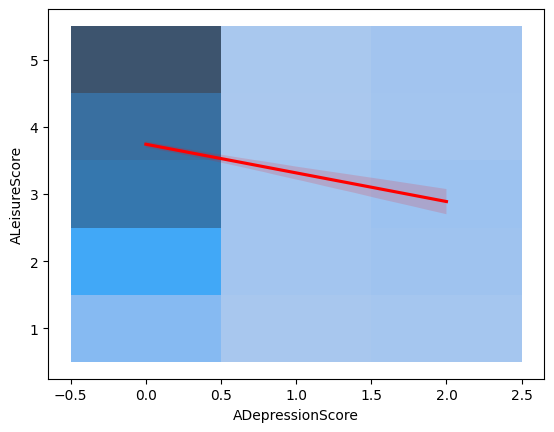

In [57]:
sns.histplot(df, x='ADepressionScore', y='ALeisureScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

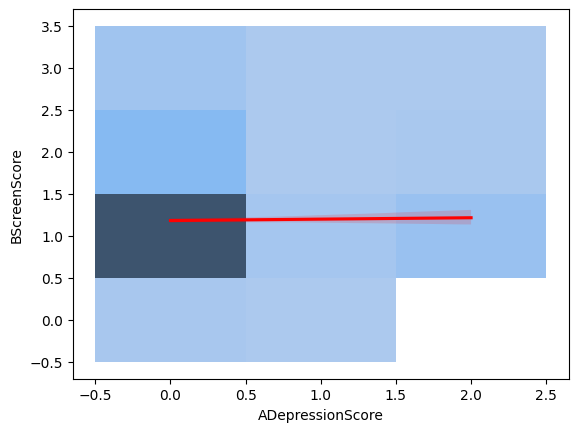

In [58]:
sns.histplot(df, x='ADepressionScore', y='BScreenScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 3

> Are younger people more likely to engage in screen-based leisure?

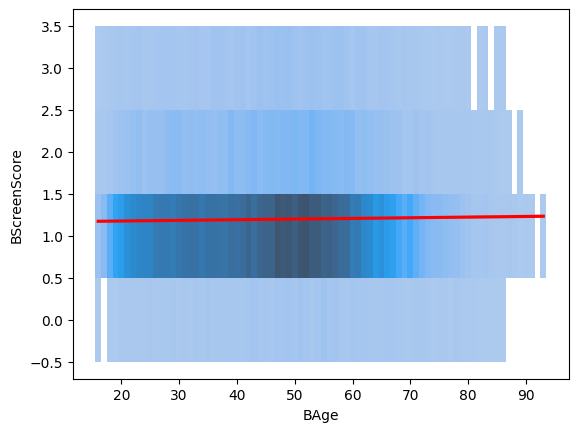

In [59]:
sub = df[df['BAge'].str.isnumeric()].copy()
sub['BAge'] = sub['BAge'].astype(int)
sns.histplot(sub, x='BAge', y='BScreenScore', discrete=(True, True))
sns.regplot(sub, x='BAge', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

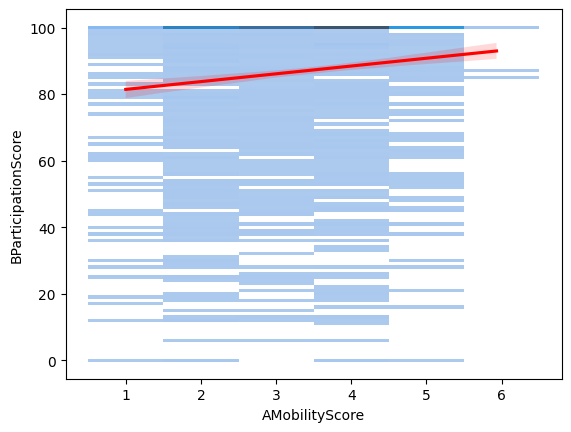

In [60]:
sns.histplot(df, x='AMobilityScore', y='BParticipationScore', discrete=(True, True))
sns.regplot(df, x='AMobilityScore', y='BParticipationScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 5

> Is lower income associated with reduced leisure and higher depression?

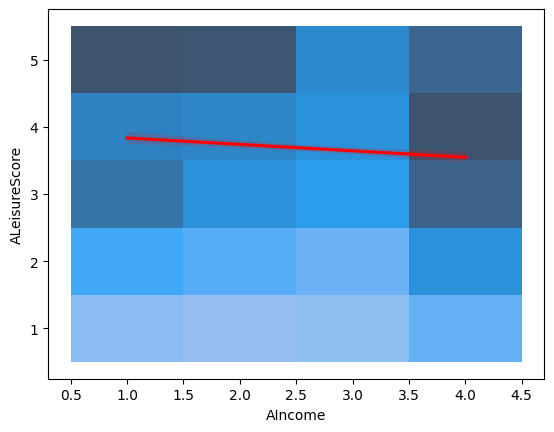

In [61]:
sns.histplot(df, x='AIncome', y='ALeisureScore', discrete=(True, True))
sns.regplot(df, x='AIncome', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

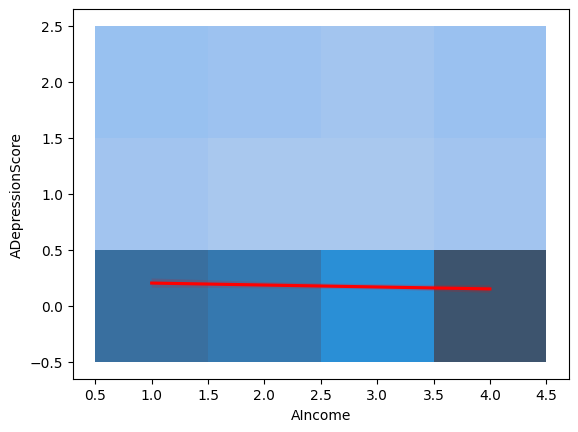

In [62]:
sns.histplot(df, x='AIncome', y='ADepressionScore', discrete=(True, True))
sns.regplot(df, x='AIncome', y='ADepressionScore', marker='', line_kws={'color':'r'})
plt.show()

## Modeling

Let's now build both linear and non-linear models taking into account all the control variables.

In [87]:
from typing import List, Any, Dict

# Core model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    r2_score,
    mean_squared_error,
    roc_curve,
    auc,
    RocCurveDisplay,
)

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model types
from sklearn.base import is_classifier, is_regressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


def train_and_evaluate_model(
    df: pd.DataFrame,
    target_col: str,
    categorical_cols: List[str],
    continuous_cols: List[str],
    model: Any,
) -> Dict[str, Any]:
    """
    Trains and evaluates a model using a full preprocessing pipeline.

    Args:
        df: The input pandas DataFrame.
        target_col: The name of the target variable column.
        categorical_cols: A list of column names for categorical features.
        continuous_cols: A list of column names for continuous features.
        model: An instantiated scikit-learn model (e.g., LogisticRegression()).

    Returns:
        A dictionary containing results needed for plotting, including:
        - 'model_type': 'classifier' or 'regressor'
        - 'y_test': The true values from the test set.
        - 'y_pred': The predicted values from the test set.
        - 'y_pred_proba': Predicted probabilities (for classifiers, else None).
        - 'model': The fitted pipeline object.
        - 'labels': Unique class labels (for classifiers, else None).
    """
    print(f"--- Starting model training for: {type(model).__name__} ---")

    # 1. Drop NAs for the target column
    df_clean = df.dropna(subset=[target_col])
    if len(df_clean) < len(df):
        print(f"Dropped {len(df) - len(df_clean)} rows with missing target.")

    # 2. Define features (X) and target (y)
    X = df_clean[categorical_cols + continuous_cols]
    y = df_clean[target_col]

    # 3. Detect model type
    model_type = None
    if is_classifier(model):
        model_type = "classifier"
    elif is_regressor(model):
        model_type = "regressor"
    else:
        raise ValueError("Model type (classifier/regressor) could not be determined.")

    print(f"Detected model type: {model_type}")

    # 4. Split the data (stratified for classifiers)
    stratify_param = y if model_type == "classifier" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=stratify_param
    )

    # 5. Build preprocessing pipelines
    # Categorical pipeline: Impute missing as 'missing', then OneHotEncode
    categorical_pipeline = Pipeline(
        steps=[
            ("to_string", FunctionTransformer(lambda x: x.astype(str))),
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]
    )

    # Continuous pipeline: Impute missing with median, then StandardScaler
    continuous_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    # 6. Combine pipelines with ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_pipeline, categorical_cols),
            ("cont", continuous_pipeline, continuous_cols),
        ],
        remainder="passthrough",  # Keep other columns if any (though we defined all)
    )

    # 7. Create the full pipeline
    full_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    for col in X_train.columns:
        # Get all unique types present in the column
        unique_types = X_train[col].apply(type).unique()
        
        # If there is more than one unique type, it's a mixed-type column
        if len(unique_types) > 1:
            print(f"**Mixed-Type Column Found:** '{col}'")
            print(f"  - Detected Types: {unique_types}")

    # 8. Train the model
    print("Fitting model pipeline...")
    full_pipeline.fit(X_train, y_train)

    # 9. Perform classification/regression
    y_pred = full_pipeline.predict(X_test)
    y_pred_proba = None
    labels = None

    # 10. Print summary and get plotting data
    if model_type == "classifier":
        labels = sorted(y.unique())
        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred))
        if hasattr(full_pipeline, "predict_proba"):
            y_pred_proba = full_pipeline.predict_proba(X_test)

    elif model_type == "regressor":
        print("\n--- Regression Report ---")
        print(f"R-squared (R²): {r2_score(y_test, y_pred):.4f}")
        print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
        print(
            f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}"
        )

    print(f"--- Model training complete for: {type(model).__name__} ---")

    # 11. Return necessary info for plotting
    return {
        "model_type": model_type,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
        "model": full_pipeline,
        "labels": labels,
    }


# --- Plotting Functions ---


def plot_confusion_matrix(
    y_test: pd.Series, y_pred: np.ndarray, labels: List[Any]
):
    """Plots a seaborn confusion matrix."""
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


def plot_roc_curve(y_test: pd.Series, y_pred_proba: np.ndarray, labels: List[Any]):
    """Plots the ROC curve for binary or multiclass classification."""
    if y_pred_proba is None:
        print("ROC curve not available (model does not support predict_proba).")
        return

    # Binary classification
    if len(labels) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=labels[1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:0.2f})",
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()
    else:
        # Multiclass: One-vs-Rest (OvR)
        # Binarize the output
        y_test_binarized = label_binarize(y_test, classes=labels)
        n_classes = len(labels)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        print("Plotting One-vs-Rest (OvR) ROC curves for multiclass target.")
        plt.figure(figsize=(10, 8))

        # Plot all ROC curves
        for i, label in enumerate(labels):
            plt.plot(
                fpr[i],
                tpr[i],
                lw=2,
                label=f"ROC curve for class {label} (area = {roc_auc[i]:0.2f})",
            )

        plt.plot([0, 1], [0, 1], "k--", lw=2, label="No Skill")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multiclass One-vs-Rest ROC")
        plt.legend(loc="lower right")
        plt.show()


def plot_residuals(y_test: pd.Series, y_pred: np.ndarray):
    """Plots a residual plot for regression models."""
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.show()


def plot_actual_vs_predicted(y_test: pd.Series, y_pred: np.ndarray):
    """Plots actual vs. predicted values for regression models."""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    # Add a 45-degree line for reference
    lims = [
        min(min(y_test), min(y_pred)),
        max(max(y_test), max(y_pred)),
    ]
    plt.plot(lims, lims, "r--", alpha=0.75, label="Perfect Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted")
    plt.legend()
    plt.axis("square")
    plt.show()


def run_plots(plot_data: Dict[str, Any]):
    """
    Runs the appropriate plots based on model type.

    Args:
        plot_data: The dictionary returned by train_and_evaluate_model.
    """
    model_type = plot_data["model_type"]
    y_test = plot_data["y_test"]
    y_pred = plot_data["y_pred"]

    if model_type == "classifier":
        labels = plot_data["labels"]
        y_pred_proba = plot_data["y_pred_proba"]
        plot_confusion_matrix(y_test, y_pred, labels)
        plot_roc_curve(y_test, y_pred_proba, labels)
    elif model_type == "regressor":
        plot_residuals(y_test, y_pred)
        plot_actual_vs_predicted(y_test, y_pred)

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

We'll fit a logistic regression model for `ALeisureScore` using `AFunctionalScore` and the control variables defined above, then visualise the relationship and the model coefficients.

--- Starting model training for: LogisticRegression ---
Dropped 128898 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         1.0       0.14      0.07      0.10        28
         2.0       0.15      0.14      0.15        56
         3.0       0.32      0.30      0.31       113
         4.0       0.35      0.36      0.35       117
         5.0       0.45      0.51      0.48       150

    accuracy                           0.35       464
   macro avg       0.28      0.28      0.28       464
weighted avg       0.34      0.35      0.34       464

--- Model training complete for: LogisticRegression ---


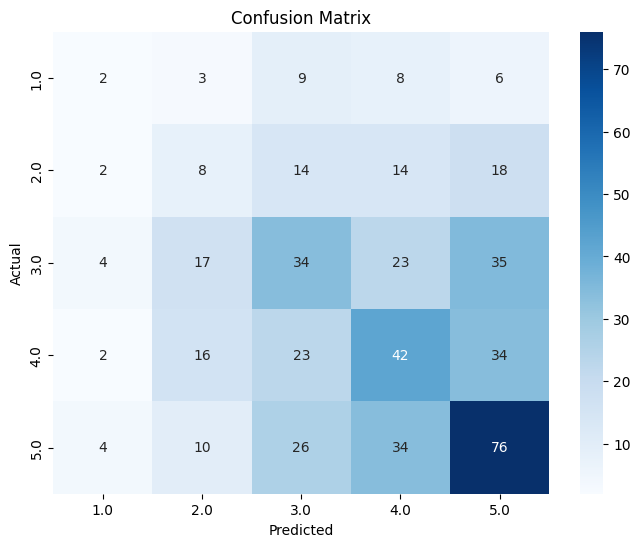

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


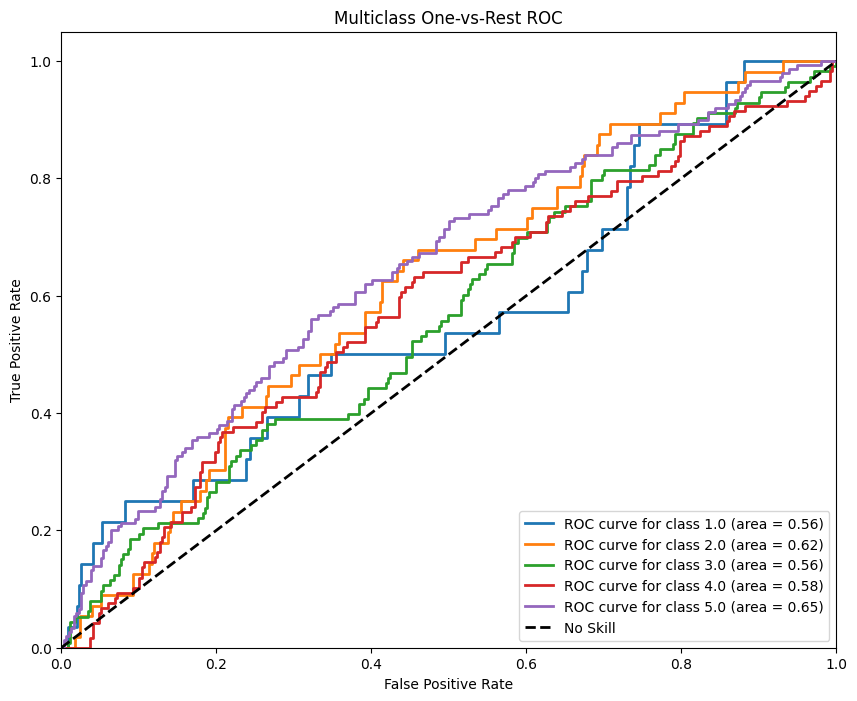

In [97]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df,
    'ALeisureScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: LogisticRegression ---
Dropped 101293 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.10      0.01      0.02       163
         1.0       0.80      0.99      0.89      4769
         2.0       0.39      0.04      0.07       769
         3.0       0.15      0.01      0.02       284

    accuracy                           0.80      5985
   macro avg       0.36      0.26      0.25      5985
weighted avg       0.70      0.80      0.72      5985

--- Model training complete for: LogisticRegression ---


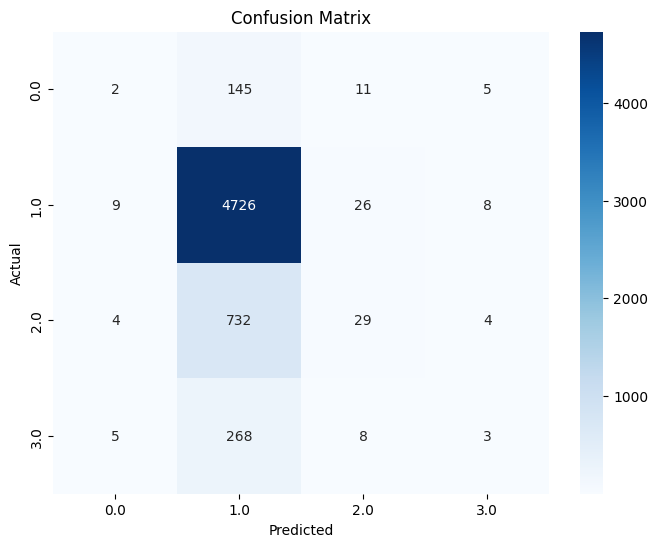

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


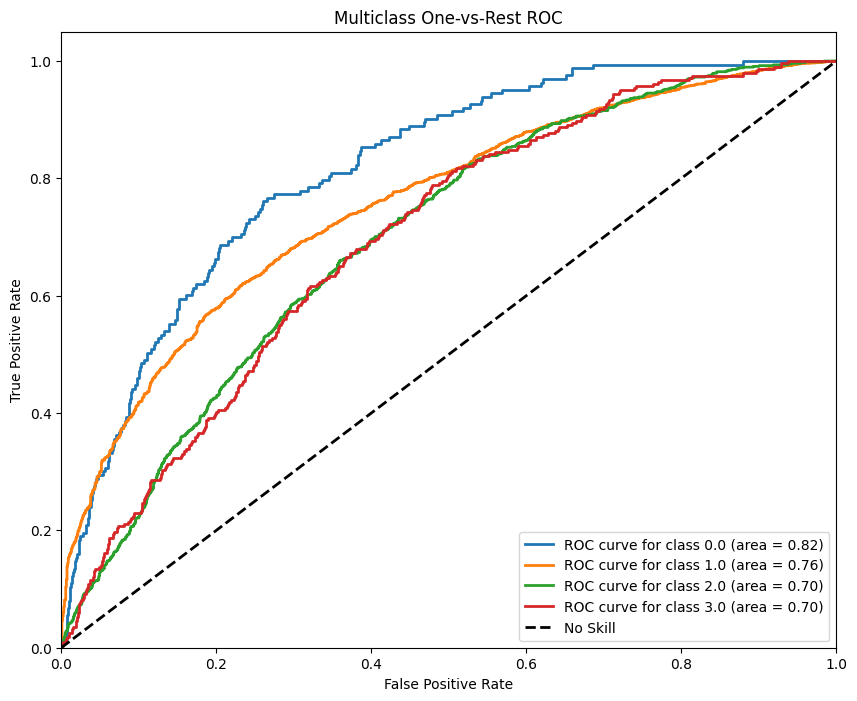

In [98]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

Let's see how results compare to a Random Forest classifier.

--- Starting model training for: RandomForestClassifier ---
Dropped 128898 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         1.0       1.00      0.04      0.07        28
         2.0       0.33      0.02      0.03        56
         3.0       0.28      0.25      0.26       113
         4.0       0.25      0.22      0.23       117
         5.0       0.39      0.67      0.49       150

    accuracy                           0.34       464
   macro avg       0.45      0.24      0.22       464
weighted avg       0.36      0.34      0.29       464

--- Model training complete for: RandomForestClassifier ---


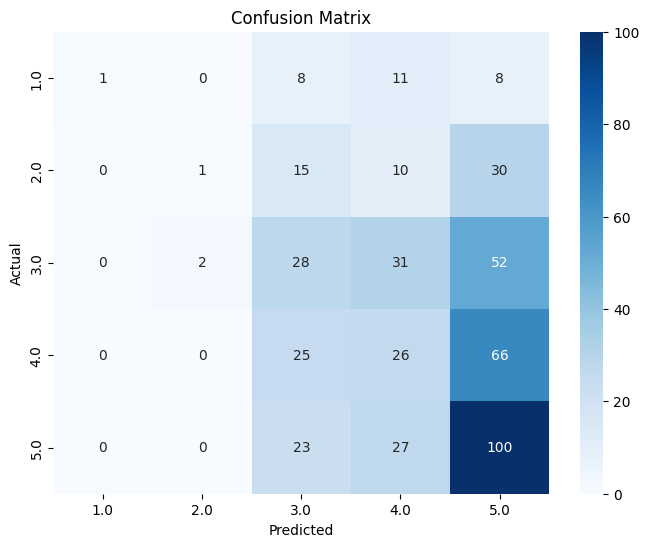

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


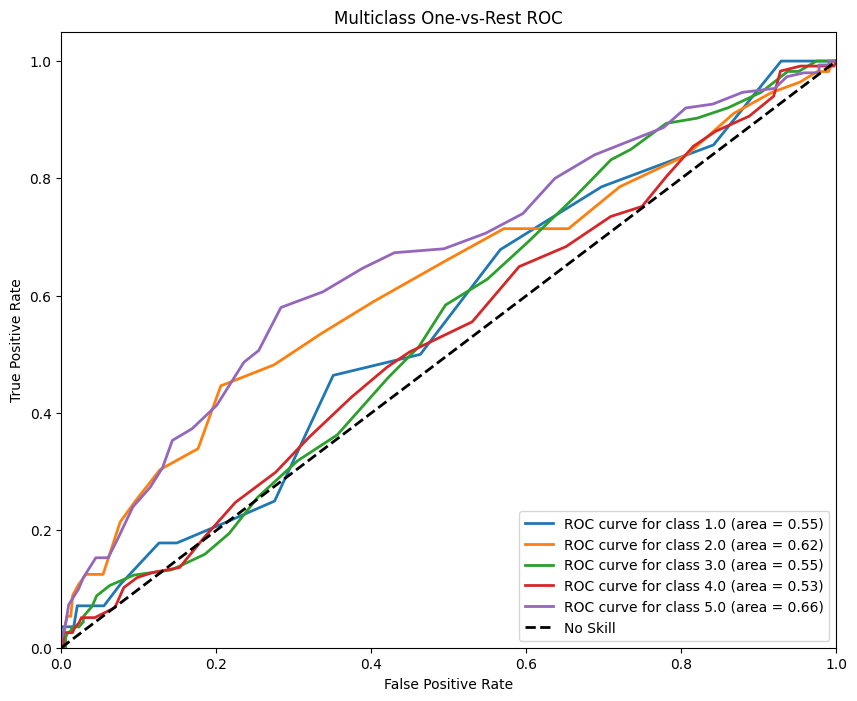

In [99]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
     df,
    'ALeisureScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

--- Starting model training for: RandomForestClassifier ---
Dropped 101293 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.33      0.01      0.01       163
         1.0       0.80      1.00      0.89      4769
         2.0       0.33      0.01      0.01       769
         3.0       0.00      0.00      0.00       284

    accuracy                           0.80      5985
   macro avg       0.37      0.25      0.23      5985
weighted avg       0.69      0.80      0.71      5985

--- Model training complete for: RandomForestClassifier ---


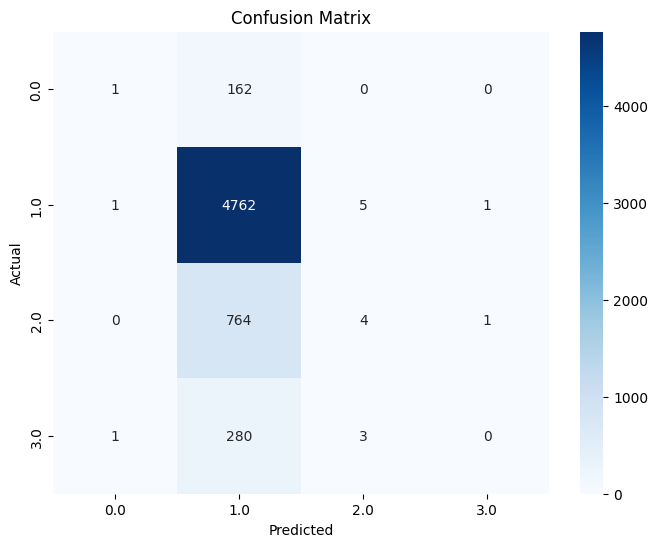

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


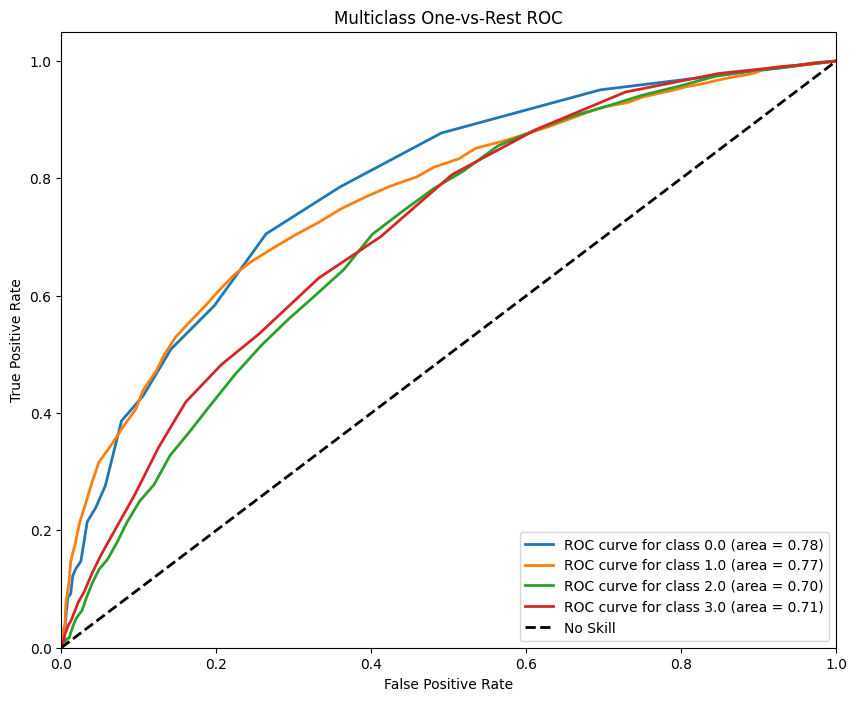

In [100]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
     df,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

### Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

_Depression score was already included above._

### Question 3

> Are younger people more likely to engage in screen-based leisure?

In [103]:
sub = df[df['BAge'].str.isnumeric()].copy()
sub['BAge'] = sub['BAge'].astype(int)

--- Starting model training for: LogisticRegression ---
Dropped 98607 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.31      0.03      0.06       160
         1.0       0.80      0.99      0.89      4672
         2.0       0.29      0.03      0.05       756
         3.0       0.47      0.03      0.05       281

    accuracy                           0.80      5869
   macro avg       0.47      0.27      0.26      5869
weighted avg       0.71      0.80      0.72      5869

--- Model training complete for: LogisticRegression ---


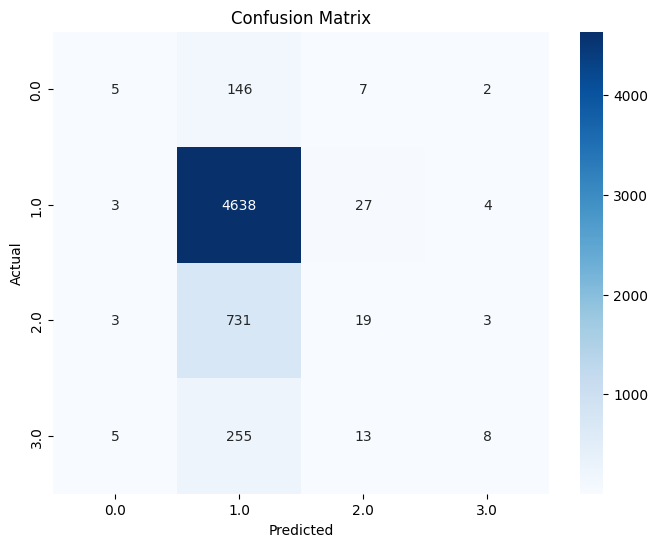

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


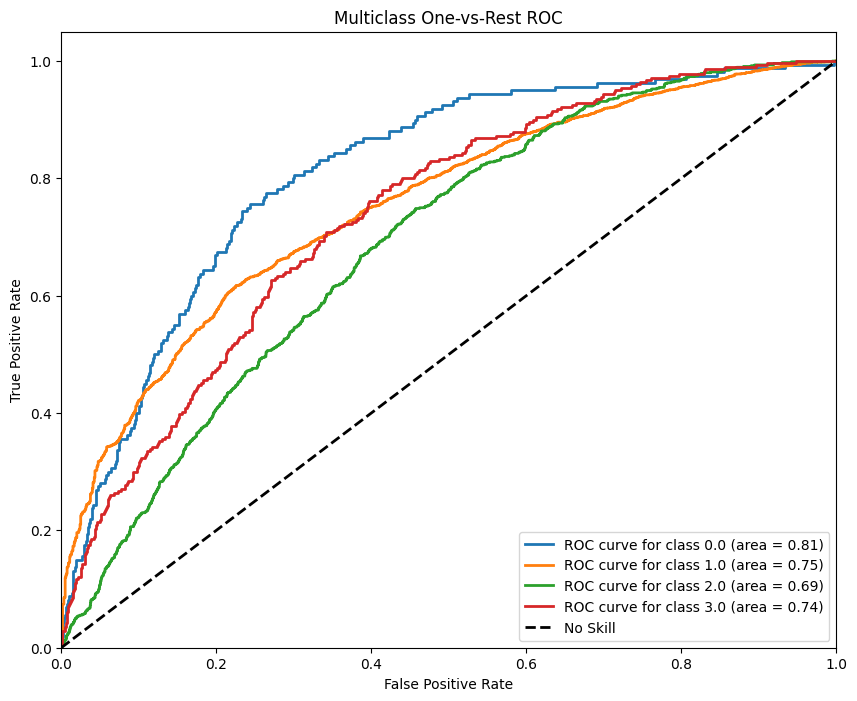

In [104]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    sub,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: RandomForestClassifier ---
Dropped 98607 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       160
         1.0       0.80      1.00      0.89      4672
         2.0       0.24      0.01      0.01       756
         3.0       0.00      0.00      0.00       281

    accuracy                           0.80      5869
   macro avg       0.26      0.25      0.22      5869
weighted avg       0.67      0.80      0.71      5869

--- Model training complete for: RandomForestClassifier ---


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

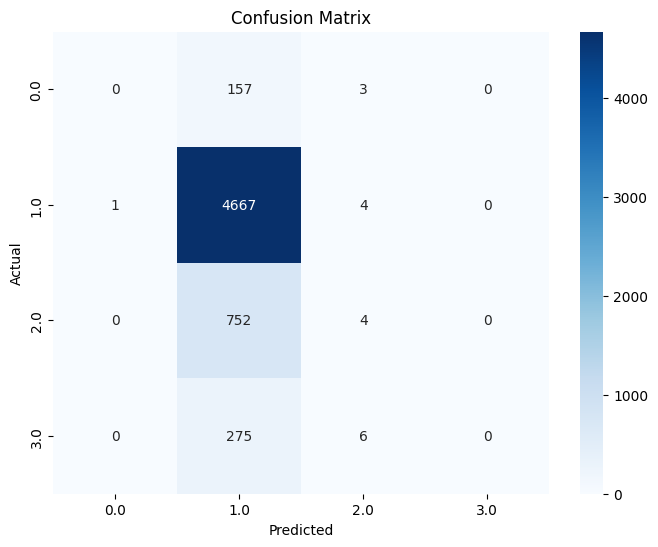

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


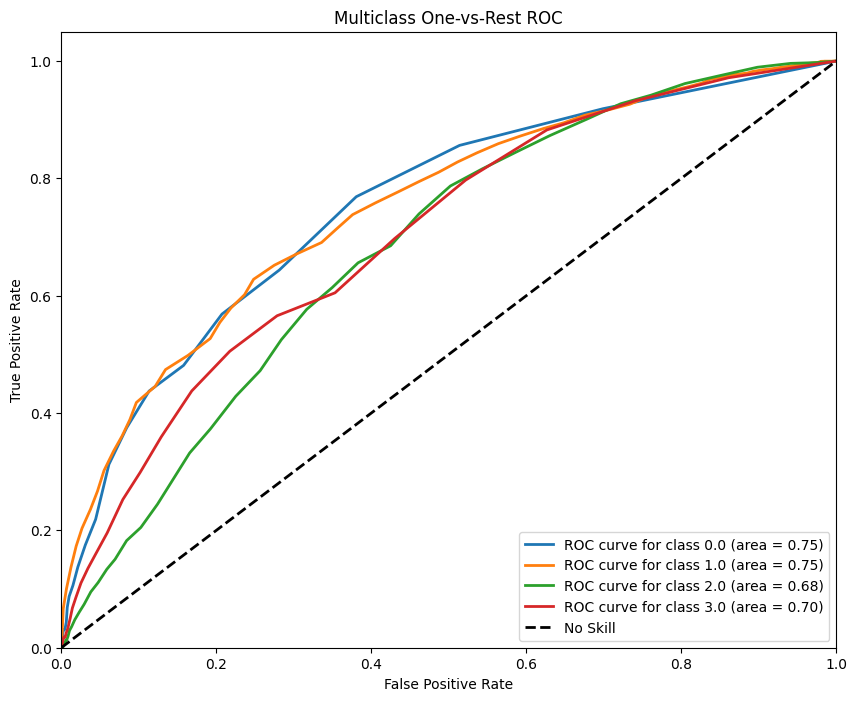

In [105]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
    sub,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

### Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

--- Starting model training for: LinearRegression ---
Dropped 84841 rows with missing target.
Detected model type: regressor
Fitting model pipeline...

--- Regression Report ---
R-squared (R²): 0.2331
Mean Squared Error (MSE): 412.7486
Root Mean Squared Error (RMSE): 20.3162
--- Model training complete for: LinearRegression ---


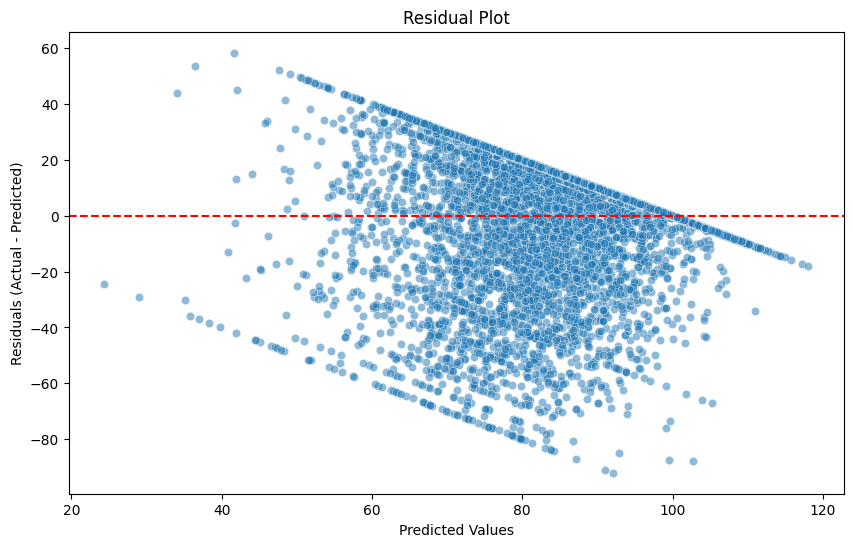

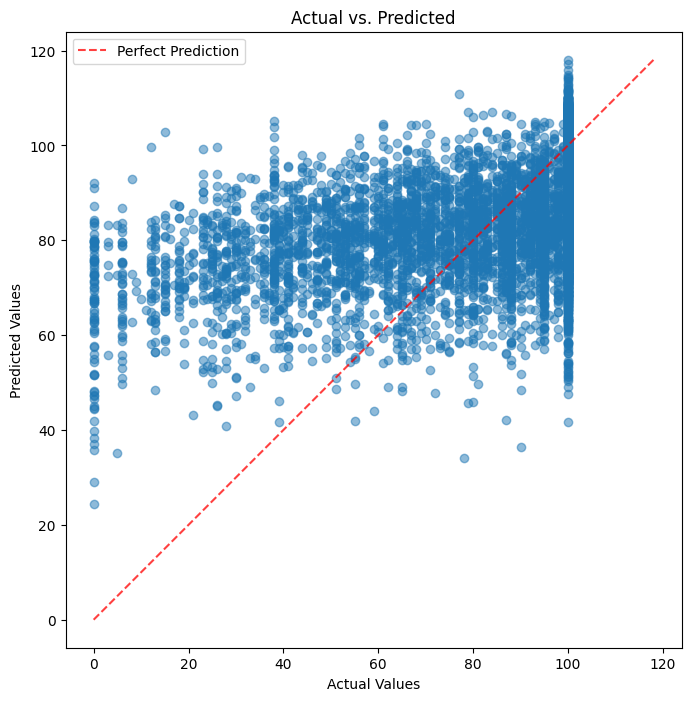

In [109]:
lin_reg = LinearRegression()

plot_data_lin = train_and_evaluate_model(
    df,
    'BParticipationScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    lin_reg,
)
run_plots(plot_data_lin)

--- Starting model training for: RandomForestRegressor ---
Dropped 84841 rows with missing target.
Detected model type: regressor
Fitting model pipeline...

--- Regression Report ---
R-squared (R²): 0.2928
Mean Squared Error (MSE): 380.6198
Root Mean Squared Error (RMSE): 19.5095
--- Model training complete for: RandomForestRegressor ---


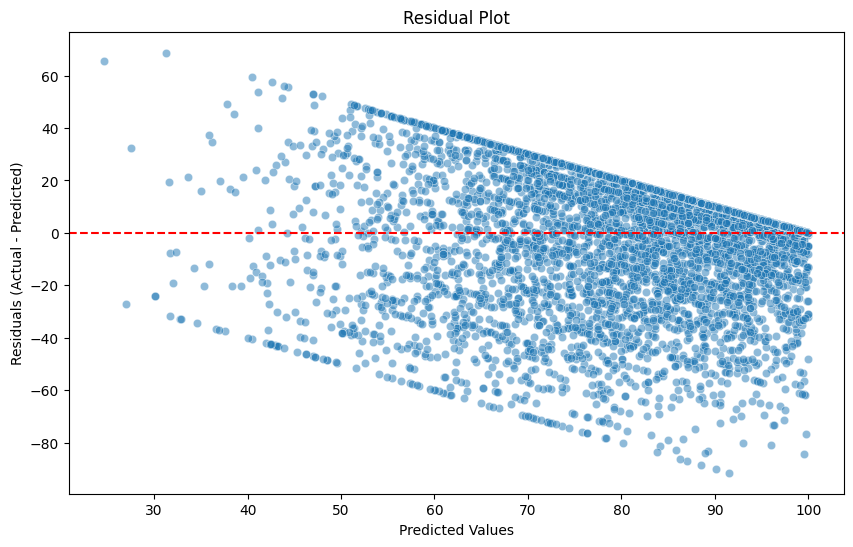

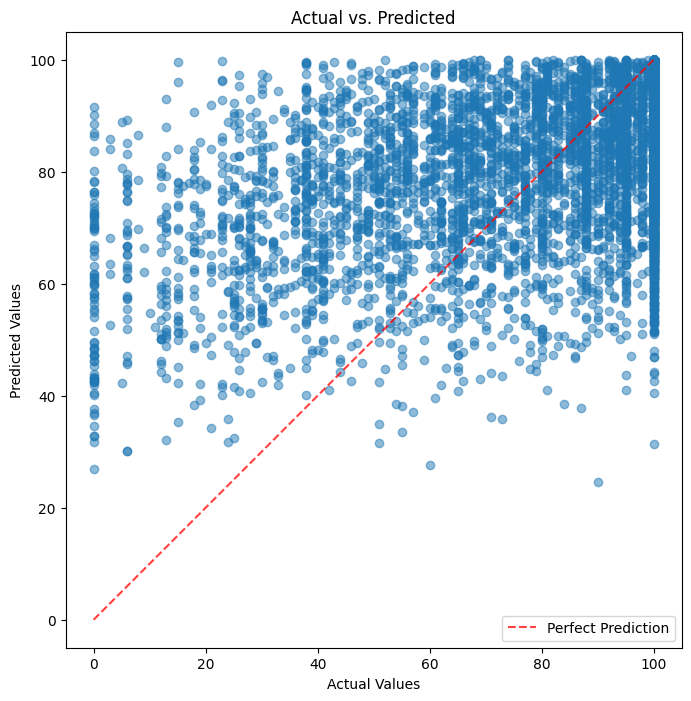

In [110]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

plot_data_rf_reg = train_and_evaluate_model(
    df,
    'BParticipationScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_reg
)

run_plots(plot_data_rf_reg)

### Question 5

> Is lower income associated with reduced leisure and higher depression?

_Leisure, see above._

--- Starting model training for: LogisticRegression ---
Dropped 128928 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       410
         1.0       0.14      0.06      0.09        16
         2.0       0.14      0.03      0.05        32

    accuracy                           0.88       458
   macro avg       0.40      0.36      0.36       458
weighted avg       0.83      0.88      0.85       458

--- Model training complete for: LogisticRegression ---


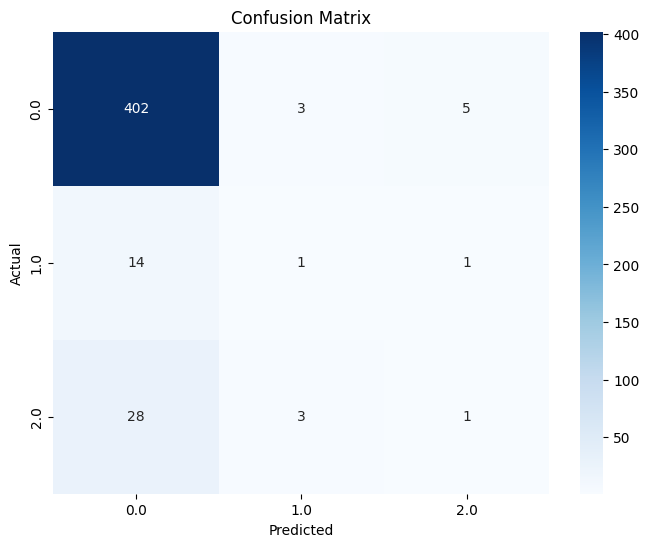

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


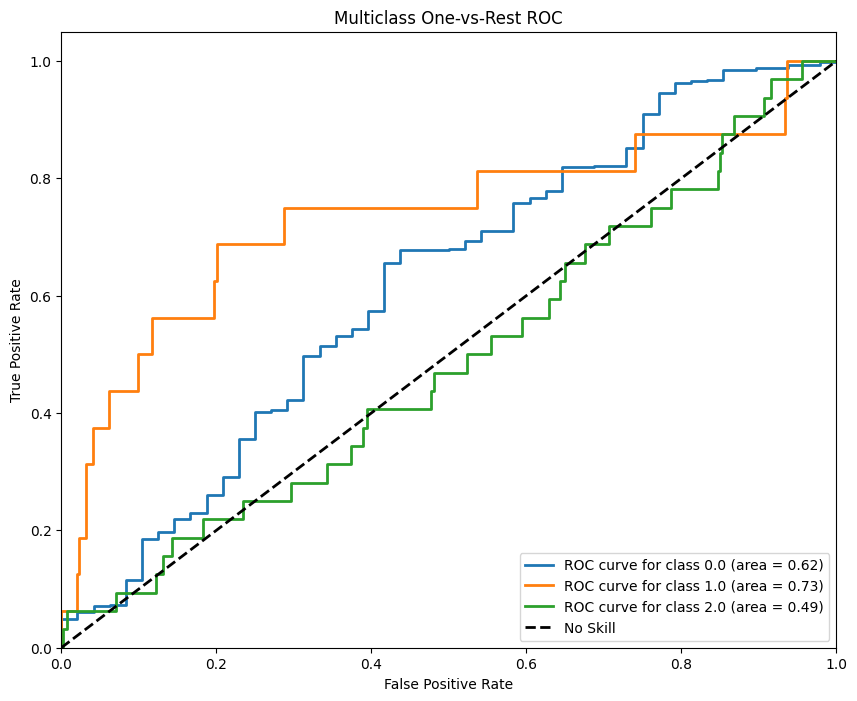

In [113]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df,
    'ADepressionScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ALeisureScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: RandomForestClassifier ---
Dropped 128928 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94       410
         1.0       0.00      0.00      0.00        16
         2.0       0.00      0.00      0.00        32

    accuracy                           0.90       458
   macro avg       0.30      0.33      0.31       458
weighted avg       0.80      0.90      0.85       458

--- Model training complete for: RandomForestClassifier ---


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

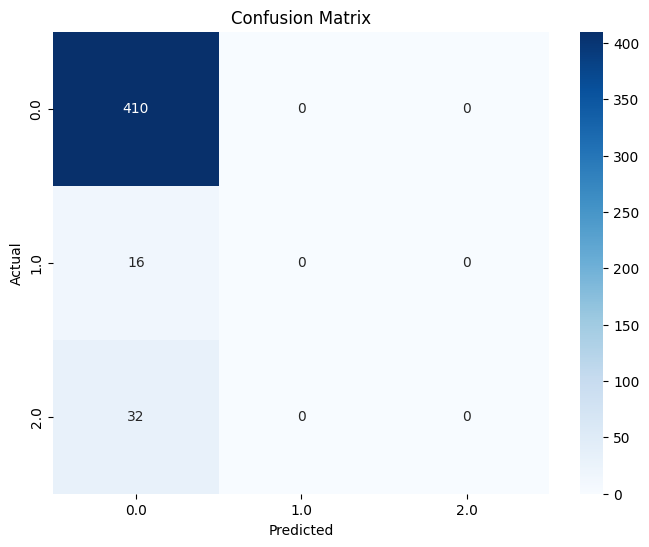

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


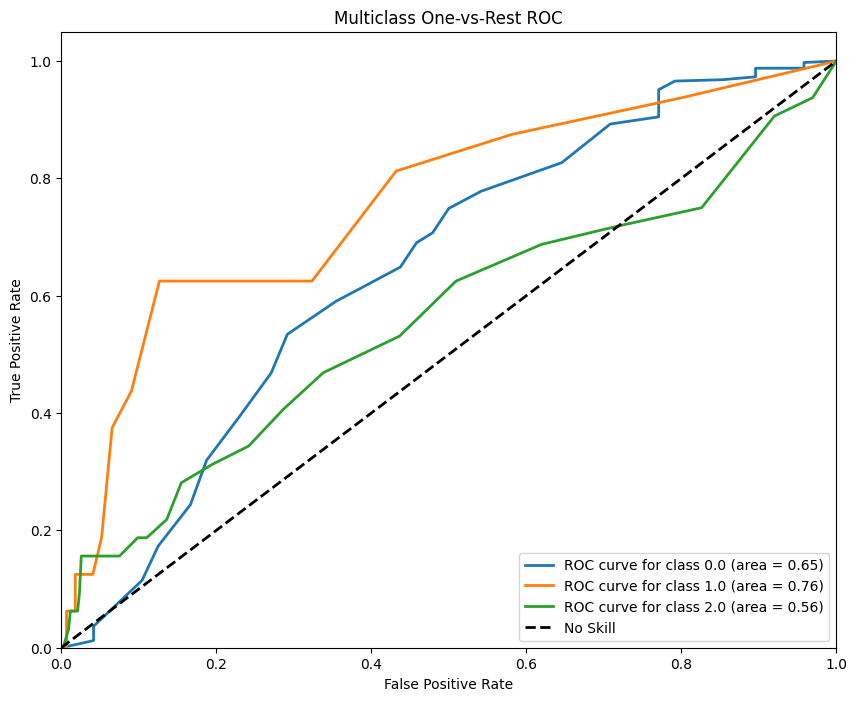

In [114]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
     df,
    'ADepressionScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ALeisureScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)